In [8]:
from os import walk

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from stats import sample_from_posterior

from pymc3_models import durw_fit, edhmm_fit

In [2]:
# get the file names
f = []
for (dirpath, dirnames, filenames) in walk('data'):
    f.extend(filenames)
    break
f = np.sort(f)[1:]

# set parameters
n_subs = len(f)  # number of subjects

T = 160  # total number of trials
last = -35  # set the time point for the post-reversal phase

# input variables for inference
inp = np.zeros((T, n_subs, 3), dtype = np.int64)

# failed trials
nans = np.zeros((T, n_subs), dtype = bool)

# format data
for i,file in enumerate(f):
    sub, _ = file.split(sep='.')
    sub = int(sub[-2:])
    data = pd.read_csv(dirpath + '/' + file)
    start = data['S'][0] 
    data = data.loc[:,'A':'R']

    # change choice labels from (1,2) to (0,1)  
    if start == 1:
        data['A'] -= 1
    else:
        # reverse labels (1,2) to (1,0) if the initial best choice was 2
        data['A'] = 2 - data['A']
      
    data['R'][data['R']==-1] = 0  # map choice outcomes from {-1,1} to {0,1}
    data['T'] = 1  # set the switch variable to one (it is set to zero only for nan trials)
    nans[:,i] = data.isnull().any(axis = 1)
    data[nans[:,i]] = 0
    data = data.astype(int)
    inp[:,i,:] = data.values

In [5]:
approx_durw = durw_fit(inp, nans, n_subs, last)

Finished [100%]: Average Loss = 783.52


In [6]:
# sample from posterior and estimate posterior predictive log-model evidence 
# for the trials excluded from model fitting
varnames = ['c0', 'beta', 'alpha', 'kappa', 'V0']
durw_sample, pplme, plike2 = sample_from_posterior(approx_durw, 
                                              varnames, 
                                              n_subs,
                                              inp[last:,:,0], 
                                              last)

# pplme -> provides posterior predictive log-model evidence 
# estimated over the 'last' trials for each participant 
# from 10000 predictive samples from the posterior

# plike2 -> provides response likelihood per trial over the 'last' trials, 
# averaged over 10000 predictive samples from the posterior

# uncomment for storing reults in HDF5 format
# store = pd.HDFStore('behaivor_fits.h5')
# store['durw/trace'] = sample
# store['durw/pplme'] = pd.Series(pplme)
# store['durw/plike2'] = pd.DataFrame(plike2)
# store.close()

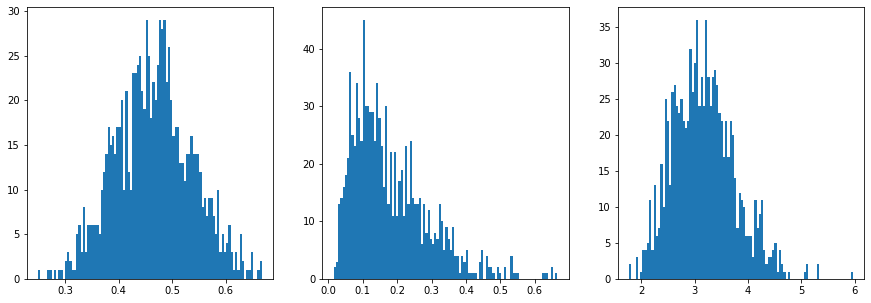

In [9]:
subject = 0  # integer value between 0 and 21

fig, axes = plt.subplots(1, 3, figsize=(15, 5));
axes[0].hist(durw_sample['alpha__{}'.format(subject)], bins=100);
axes[1].hist(durw_sample['kappa__{}'.format(subject)], bins=100);
axes[2].hist(durw_sample['beta__{}'.format(subject)], bins=100);

In [11]:
approx_edhmm = edhmm_fit(inp, nans, n_subs, last)

Finished [100%]: Average Loss = 840.68


In [12]:
varnames = ['c0', 'beta', 'delta', 'r', 'muA', 'muB']
edhmm_sample, pplme, plike2 = sample_from_posterior(approx_edhmm, 
                                              varnames, 
                                              n_subs,
                                              inp[last:,:,0], 
                                              last)

# uncomment for storing results in HDF5 format
# store = pd.HDFStore('behavior_fits.h5')
# store['edhmm/trace'] = sample
# store['edhmm/pplme'] = pd.Series(pplme)
# store['edhmm/plike2'] = pd.DataFrame(plike2)
# store.close()

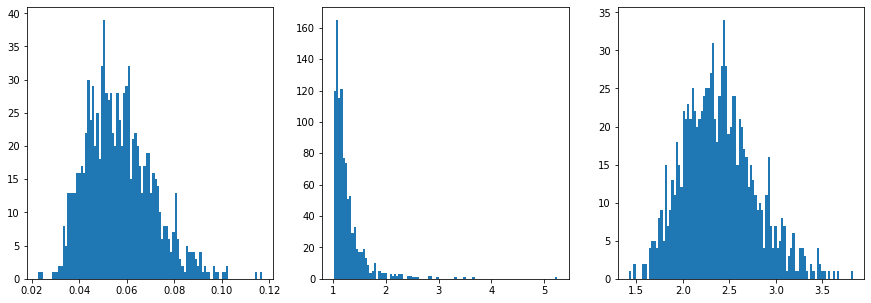

In [23]:
subject = 0  # integer value between 0 and 21

fig, axes = plt.subplots(1, 3, figsize=(15, 5));
axes[0].hist(edhmm_sample['delta__{}'.format(subject)], bins=100);
axes[1].hist(edhmm_sample['r__{}'.format(subject)], bins=100);
axes[2].hist(edhmm_sample['beta__{}'.format(subject)], bins=100);